# **Complaint Dataset - UnivEnc - IID setting**

## Download and import the necessary libraries

In [ ]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
get_ipython().system('pip install dgl')

     |████████████████████████████████| 4.4MB 15.5MB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import scipy as sp
import pandas as pd

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score, precision_recall_curve
import copy

import dgl
from dgl.data import DGLDataset
import torch


import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F
import random
import os
from operator import add

from sklearn.metrics.pairwise import cosine_similarity
import heapq

import warnings
warnings.filterwarnings("ignore")

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


Using backend: pytorch


## Data loading and basic processing

In [ ]:
# This path contains the CSV file
PATH = '/content/drive/MyDrive/Tweets/sent_final_preds.csv'

df = pd.read_csv(PATH, sep = ",")

df = df.sample(frac=1).reset_index(drop=True) 
df.head(2)

Unnamed: 0  ... Sentiment_Final
0        1319  ...        Negative
1         280  ...         Neutral

[2 rows x 7 columns]

In [ ]:
labels = []
sentim = []

for i in range(len(df)):
    labels.append(df.Labels[i])
    if df.Sentiment_Vader[i] == 'Negative':
        sentim.append(0)
    if df.Sentiment_Vader[i] == 'Neutral':
        sentim.append(1)
    if df.Sentiment_Vader[i] == 'Positive':
        sentim.append(2)

In [ ]:
# Apply universal sentence encoder on each tweet
# Input  : String
# Output : 512 long vector

tweets = []

for tweet in df['Tweets']:
  tweets.append(embed([tweet]))

tweets = np.stack(tweets).reshape((len(df), 512))
df1 = pd.DataFrame(tweets)
df1.head(3)

0         1         2    ...       509       510       511
0  0.062553  0.063813  0.000723  ... -0.047620  0.045081 -0.026102
1  0.013010 -0.069110 -0.073573  ...  0.045356 -0.034610 -0.019459
2 -0.033765  0.055732  0.087102  ...  0.027181 -0.059071 -0.001484

[3 rows x 512 columns]

In [ ]:
# Divide all 3 datapoints (embeddings, sentiment label, complaint label) into 5 parts (5 clients)
# Data considered to be IID

df_dummy = df1.copy()
#df_dummy['target'] = df.Labels

l = len(df)//5

df_1 = df_dummy[:l]
labels1 = labels[:l]
sentim1 = sentim[:l]

df_2 = df_dummy[l:2*l]
labels2 = labels[l:2*l]
sentim2 = sentim[l:2*l]

df_3 = df_dummy[2*l:3*l]
labels3 = labels[2*l:3*l]
sentim3 = sentim[2*l:3*l]

df_4 = df_dummy[3*l:4*l]
labels4 = labels[3*l:4*l]
sentim4 = sentim[3*l:4*l]

df_5 = df_dummy[4*l:]
labels5 = labels[4*l:]
sentim5 = sentim[4*l:]


df_1.to_csv('UE_IID_C1.csv', index = False)
df_2.to_csv('UE_IID_C2.csv', index = False)
df_3.to_csv('UE_IID_C3.csv', index = False)
df_4.to_csv('UE_IID_C4.csv', index = False)
df_5.to_csv('UE_IID_C5.csv', index = False)

## Edge creation

In [ ]:
# Creates edges between the tweets based on their cosine similarity
# Input  : A dataframe where each row is embed(tweet)
# Output : A dataframe representing the edge connection between the nodes

def edger(df):

    cos_res_temp = cosine_similarity(df, df)

    for i in range(len(cos_res_temp)):
        ind = heapq.nlargest(3, range(len(cos_res_temp[i])), key=lambda x: cos_res_temp[i][x])
        for j in ind:
            cos_res_temp[i][j] = 1

    # Consider tweet only if cosine similarity > 0.75 
    cos_res = (cos_res_temp - 0.25).round() - np.identity(len(cos_res_temp))
    degree = np.sum(cos_res, axis = 1)

    print('Max degree:', max(degree), '\nMin degree:', min(degree), '\nAvg degree:', sum(degree)/len(degree))

    cnt=0
    start_indx  = []
    end_idx = []
    weights = []

    for i in range(len(df)):
        for j in range(len(df)):
            
            if cos_res[i][j]==1 :
                cnt+=1
                start_indx.append(i)
                end_idx.append(j)

    edge_dataFrame = pd.DataFrame({'target':start_indx, 'source':end_idx})

    return edge_dataFrame

In [ ]:
# 5 clients, 5 graphs, 5 edge matrices
print('Graph of client 1')
edge_dataFrame_1 = edger(df_1)

print('\nGraph of client 2')
edge_dataFrame_2 = edger(df_2)

print('\nGraph of client 3')
edge_dataFrame_3 = edger(df_3)

print('\nGraph of client 4')
edge_dataFrame_4 = edger(df_4)

print('\nGraph of client 5')
edge_dataFrame_5 = edger(df_5)

Graph of client 1
Max degree: 2.0 
Min degree: 2.0 
Avg degree: 2.0

Graph of client 2
Max degree: 2.0 
Min degree: 2.0 
Avg degree: 2.0

Graph of client 3
Max degree: 2.0 
Min degree: 2.0 
Avg degree: 2.0

Graph of client 4
Max degree: 3.0 
Min degree: 2.0 
Avg degree: 2.0029027576197387

Graph of client 5
Max degree: 2.0 
Min degree: 2.0 
Avg degree: 2.0


## Graph creation

In [ ]:
class TweetDataSet1(DGLDataset):
    def __init__(self):
        super().__init__(name='tweet_data')

    def process(self):

        node_features = torch.from_numpy(df_1.values).float()
        node_labels = torch.from_numpy(np.stack(labels1))

        edges_src = torch.from_numpy(edge_dataFrame_1['source'].to_numpy())
        edges_dst = torch.from_numpy(edge_dataFrame_1['target'].to_numpy())

        self.graph = dgl.graph((edges_src, edges_dst), num_nodes=df_1.shape[0])
        self.graph.ndata['feat'] = node_features
        self.graph.ndata['label'] = node_labels


        n_nodes = df_1.shape[0]


    def __getitem__(self, i):
        return self.graph

    def __len__(self):
        return 1

dataset1 = TweetDataSet1()
graph1 = dataset1[0]

In [ ]:
class TweetDataSet2(DGLDataset):
    def __init__(self):
        super().__init__(name='tweet_data')

    def process(self):
 
 
        node_features = torch.from_numpy(df_2.values).float()
        node_labels = torch.from_numpy(np.stack(labels2))
 
        edges_src = torch.from_numpy(edge_dataFrame_2['source'].to_numpy())
        edges_dst = torch.from_numpy(edge_dataFrame_2['target'].to_numpy())

        self.graph = dgl.graph((edges_src, edges_dst), num_nodes=df_2.shape[0])
        self.graph.ndata['feat'] = node_features
        self.graph.ndata['label'] = node_labels
 
 
        n_nodes = df_2.shape[0]

    def __getitem__(self, i):
        return self.graph

    def __len__(self):
        return 1

dataset2 = TweetDataSet2()
graph2 = dataset2[0]

In [ ]:
class TweetDataSet3(DGLDataset):
    def __init__(self):
        super().__init__(name='tweet_data')

    def process(self):

        node_features = torch.from_numpy(df_3.values).float()
        node_labels = torch.from_numpy(np.stack(labels3))

        edges_src = torch.from_numpy(edge_dataFrame_3['source'].to_numpy())
        edges_dst = torch.from_numpy(edge_dataFrame_3['target'].to_numpy())

        self.graph = dgl.graph((edges_src, edges_dst), num_nodes=df_3.shape[0])
        self.graph.ndata['feat'] = node_features
        self.graph.ndata['label'] = node_labels
        n_nodes = df_3.shape[0]


    def __getitem__(self, i):
        return self.graph

    def __len__(self):
        return 1

dataset3 = TweetDataSet3()
graph3 = dataset3[0]

In [ ]:
class TweetDataSet4(DGLDataset):
    def __init__(self):
        super().__init__(name='tweet_data')

    def process(self):

        node_features = torch.from_numpy(df_4.values).float()
        node_labels = torch.from_numpy(np.stack(labels4))

        edges_src = torch.from_numpy(edge_dataFrame_4['source'].to_numpy())
        edges_dst = torch.from_numpy(edge_dataFrame_4['target'].to_numpy())

        self.graph = dgl.graph((edges_src, edges_dst), num_nodes=df_4.shape[0])
        self.graph.ndata['feat'] = node_features
        self.graph.ndata['label'] = node_labels
        n_nodes = df_4.shape[0]

    def __getitem__(self, i):
        return self.graph

    def __len__(self):
        return 1

dataset4 = TweetDataSet4()
graph4 = dataset4[0]

In [ ]:
class TweetDataSet5(DGLDataset):
    def __init__(self):
        super().__init__(name='tweet_data')

    def process(self):

        node_features = torch.from_numpy(df_5.values).float()
        node_labels = torch.from_numpy(np.stack(labels5))

        edges_src = torch.from_numpy(edge_dataFrame_5['source'].to_numpy())
        edges_dst = torch.from_numpy(edge_dataFrame_5['target'].to_numpy())

        self.graph = dgl.graph((edges_src, edges_dst), num_nodes=df_5.shape[0])
        self.graph.ndata['feat'] = node_features
        self.graph.ndata['label'] = node_labels

        n_nodes = df_5.shape[0]
        
    def __getitem__(self, i):
        return self.graph

    def __len__(self):
        return 1

dataset5 = TweetDataSet5()
graph5 = dataset5[0]

In [ ]:
graph = [graph1, graph2, graph3, graph4, graph5]

## Model creation

In [ ]:
# A single GAT architecture (not model) which would be shared among the clients
# Later averaged to get the global GAT model

class FED_GAT(nn.Module):

    def __init__(self, in_feats, out_feats):
        super().__init__()
        
        h1 = 256 * 1
        h2 = 128 * 1
        h3 = 32 * 1

        # 3-GAT shared layers
        self.gat1 = dglnn.conv.GATConv(in_feats = in_feats, out_feats = h1, num_heads = 8, attn_drop = 0.5, residual  = True, feat_drop = 0.75)
        self.gat2 = dglnn.conv.GATConv(in_feats = h1, out_feats = h2, num_heads = 12, attn_drop = 0.5, residual  = True, feat_drop = 0.75)
        self.gat3 = dglnn.conv.GATConv(in_feats = h2, out_feats = h3, num_heads = 8, attn_drop = 0.5, residual  = True, feat_drop = 0.75)
        
        # 1-Linear layer for complaint identification
        self.dense1 = torch.nn.Linear(in_features = h1 + h2 + h3, out_features = h3)
        self.dense2 = torch.nn.Linear(in_features = h3, out_features = 2)
        
        # 2-Linear layers for sentiment identification
        self.dense3 = torch.nn.Linear(in_features = h1 + h2 + h3, out_features = h3)
        self.dense4 = torch.nn.Linear(in_features = h3, out_features = 3)

    def forward(self, graph, inputs):

        h1 = self.gat1(graph, inputs)
        h1 = F.relu(h1.mean(dim=1))

        h2 = self.gat2(graph, h1)
        h2 = F.relu(h2.mean(dim=1))
        
        h3 = self.gat3(graph, h2)
        h3 = F.relu(h3.mean(dim=1))

        h4 = self.dense1(torch.hstack((h1, h2, h3)))
        h5 = self.dense2(F.relu(h4))

        h6 = self.dense3(torch.hstack((h1, h2, h3)))
        h7 = self.dense4(F.relu(h6))

        return [torch.sigmoid(h5), h7]

## Feature initialization

In [ ]:
node_features = [graph1.ndata['feat'], graph2.ndata['feat'], graph3.ndata['feat'], 
                 graph4.ndata['feat'], graph5.ndata['feat']]

node_labels = [graph1.ndata['label'].long(), graph2.ndata['label'].long(), graph3.ndata['label'].long(),
               graph4.ndata['label'].long(), graph5.ndata['label'].long()]

n_features = [node_features[0].shape[1], node_features[1].shape[1], node_features[2].shape[1],
               node_features[3].shape[1], node_features[4].shape[1]]

n_labels = [int(node_labels[0].max().item() + 1), int(node_labels[1].max().item() + 1), int(node_labels[2].max().item() + 1),
            int(node_labels[3].max().item() + 1), int(node_labels[4].max().item() + 1)]

In [ ]:
sentiment_labels = [np.stack(sentim1), np.stack(sentim2), np.stack(sentim3),
                    np.stack(sentim4), np.stack(sentim5)]

## Model training

In [ ]:
def evaluate(model, graph, features, labels, mask, shall_i_print = True, shall_i_roc = False):

    model.eval()

    with torch.no_grad():
        [logits, dummy] = model(graph, features)
        logits = logits[mask]
        labels = labels[mask]
        k, indices = torch.max(logits, dim=1)
        
        preds = []
        roc_pred = []

        for i in logits:
            preds.append(np.argmax(i))
            roc_pred.append(i[1])


        report = classification_report(labels, preds, labels=[0, 1])

        f_0 = int(report.split('.')[3].split(' ')[0])/100
        f_1 = int(report.split('.')[6].split(' ')[0])/100

        if shall_i_print == True:
            print(report)

        if shall_i_roc == True:
            fpr, tpr, thresholds = roc_curve(labels, roc_pred)
            plt.figure(figsize=(7, 7))
            plt.plot(fpr, tpr)
            plt.scatter(fpr, tpr)
            plt.title("ROC Curve")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")

    return f_0,f_1


In [ ]:
def fed_setting():

    path = '/content/drive/MyDrive/Tweets/UnivEnc/UE_Amazon_Best.pt'
    # 1 global model
    fed_glob = FED_GAT(in_feats = n_features[0], out_feats = n_labels[0])
    fed_glob.load_state_dict(torch.load(path))

    # 5 clients - 5 models
    fed_client1 = FED_GAT(in_feats = n_features[0], out_feats = n_labels[0])
    fed_client1.load_state_dict(torch.load(path))

    fed_client2 = FED_GAT(in_feats = n_features[1], out_feats = n_labels[1])
    fed_client2.load_state_dict(torch.load(path))

    fed_client3 = FED_GAT(in_feats = n_features[2], out_feats = n_labels[2])
    fed_client3.load_state_dict(torch.load(path))

    fed_client4 = FED_GAT(in_feats = n_features[3], out_feats = n_labels[4])
    fed_client4.load_state_dict(torch.load(path))

    fed_client5 = FED_GAT(in_feats = n_features[4], out_feats = n_labels[4])
    fed_client5.load_state_dict(torch.load(path))

    return fed_glob, [fed_client1, fed_client2, fed_client3, fed_client4, fed_client5]

In [ ]:
valid_split = 0.1
test_split = 0.2
epochs = 10
learn_rate = 10e-4
die = 10e-6
comm_round = 100

def mask_generator(l, k):

    kfold_train_mask = []
    kfold_valid_mask = []
    kfold_test_mask = []
    ld = int((1-test_split) * l)
    valid_split_new = l * valid_split / ld

    for i in range(k):

        dummy = []
        dummy = [True for i in range(l)]
        start = int(i*(((1-valid_split_new)*ld)/k))
        dummy[start:(start + int(valid_split_new*ld))] = [False for i in range(int(valid_split_new*ld))]
        dummy[ld:] = [False for i in range(l-ld)]
        kfold_train_mask.append(dummy)

        dummy = []
        dummy = [False for i in range(l)]
        dummy[start:(start + int(valid_split_new*ld))] = [True for i in range(int(valid_split_new*ld))]
        dummy[ld:] = [False for i in range(l-ld)]
        kfold_valid_mask.append(dummy)

        dummy = []
        dummy = [False for i in range(l)]
        dummy[ld:] = [True for i in range(l-ld)]
        kfold_test_mask.append(dummy)

    #print('Length of training data:', ld-int(valid_split_new*ld),'(', np.round(100*((ld-int(valid_split_new*ld))/l)), ')', '\nLength of validation data:', int(valid_split_new*ld), '(', np.round((100*valid_split_new*ld)/l), ')' )
    return kfold_train_mask, kfold_valid_mask, kfold_test_mask
        

## FEDAVG

In [ ]:
def FEDAVG(g, model, sentiment_labels, i): 

    sentiment_labels = torch.from_numpy(sentiment_labels[i])
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate, weight_decay = die)
    
    best_val_acc = 0
    best_test_acc = 0
    best_f1 = 0

    features = g.ndata['feat']
    labels = g.ndata['label']

    train_mask, val_mask, test_mask = mask_generator(len(labels), epochs)

    for e in range(epochs):
        # Forward
        [logits1, logits2] = model(g, features)

        # Compute prediction
        pred1 = logits1.argmax(1)
        pred2 = logits2.argmax(1)

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        loss1 = F.cross_entropy(logits1[train_mask[e]], labels[train_mask[e]])

        criterion = torch.nn.CrossEntropyLoss() # This criterion combines LogSoftmax and NLLLoss in one single class.
        loss2 = criterion(logits2[train_mask[e]], sentiment_labels[train_mask[e]])

        loss = (2*loss1 + loss2)/3

        # Compute accuracy on training/validation/test
        train_acc1 = (pred1[train_mask[e]] == labels[train_mask[e]]).float().mean()
        val_acc1 = (pred1[val_mask[e]] == labels[val_mask[e]]).float().mean()

        #print(pred2, sentiment_labels)
        train_acc2 = (pred2[train_mask[e]] == sentiment_labels[train_mask[e]]).float().mean()
        val_acc2 = (pred2[val_mask[e]] == sentiment_labels[val_mask[e]]).float().mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        f1_0, f1_1 = evaluate(model, g, features, labels, val_mask[e], False, False)

        
        if best_f1 < (f1_0 + f1_1)/2:
            best_val_acc = val_acc1
            best_f1 = (f1_0 + f1_1)/2
            torch.save(model.state_dict(), '/content/drive/MyDrive/Tweets/UnivEnc/UE_IID_FEDAVG.pt')

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



    # print('Client {},node loss : {:.3f}, node train acc : {:.3f} node val acc : {:.3f}'.format(
    #     i, loss1, train_acc1, val_acc1))
    
    model.load_state_dict(torch.load('/content/drive/MyDrive/Tweets/UnivEnc/UE_IID_FEDAVG.pt'))
            #print('Client {}, sent loss : {:.3f}, sent train acc : {:.3f} sent val acc : {:.3f}, sent test acc : {:.3f}'.format(i, loss2, train_acc2, val_acc2, test_acc2))
            

In [ ]:
# FEDAVG

fedavg_f1_0 = 0
fedavg_f1_1 = 0
fedavg = 0

fed_glob, all_clients = fed_setting()

zero_client = FED_GAT(in_feats = n_features[0], out_feats = n_labels[0])

for p in zero_client.parameters():
    p.data = p.data * 0


fedavg_plot1 = []
fedavg_plot2 = []

print('FedAvg ->', 'epochs:', epochs, 'comm_round:', comm_round, 'LR:', learn_rate, 'decay:', die)

for comm_rounds in range(comm_round):
        
    #print('Communication Round :', comm_rounds+1)

    train_ind = random.sample(range(0, len(all_clients)), 3)
    train_ind = sorted(train_ind)

    test_ind = [i for i in range(len(all_clients))]
    
    for ind in train_ind:
        test_ind.remove(ind)
        
    train_clients = []
    test_clients = []

    for ind in train_ind:
        train_clients.append(all_clients[ind])
    
    for clients in all_clients:
        if clients not in train_clients:
            test_clients.append(clients)

    old_params = []
    new_params = []
    
    for ind in train_ind:
        
        dummy = []

        FEDAVG(graph[ind], all_clients[ind], sentiment_labels, ind)


    # Aggregate the weights and update all

    fed_glob.load_state_dict(zero_client.state_dict()) 

    for ind in train_ind:
        for p1, p2 in zip(fed_glob.parameters(), all_clients[ind].parameters()):
            p1.data = p1.data + p2.data


    for p in fed_glob.parameters():
        p.data = p.data / len(train_ind)

    for client_model in all_clients:
        client_model.load_state_dict(fed_glob.state_dict()) 
        

    for ind, client_model in zip(test_ind, test_clients):
        
        #print('\nTesting on Client', ind)
        f10, f11 = evaluate(fed_glob, graph[ind], node_features[ind], node_labels[ind], [True for i in range(len(node_labels[ind]))], False, False)
        fedavg_f1_0 += f10
        fedavg_f1_1 += f11
        fedavg += 1
    
    if len(test_clients) == 0:

        # Testing on all clients (test) data
        for ind in range(len(all_clients)):
            #print('\nTesting on Client', ind)
            test_mask = [False for i in range(len(node_labels[ind]))]
            test_mask[:int(test_split*len(node_labels[ind]))] = [True for i in range(int(test_split*len(node_labels[ind])))]
            f10, f11 = evaluate(fed_glob, graph[ind], node_features[ind], node_labels[ind], test_mask, False, False)
            fedavg_f1_0 += f10
            fedavg_f1_1 += f11
            fedavg += 1
            
    print('Communication Round', comm_rounds,'-> Class0 avg F1 :', np.round(fedavg_f1_0/fedavg, 3), '; Class1 avg F1:', np.round(fedavg_f1_1/fedavg, 3))
    
    fedavg_plot1.append(np.round(fedavg_f1_0/fedavg, 3))
    fedavg_plot2.append(np.round(fedavg_f1_1/fedavg, 3))
    #print('----------------------------------------')

torch.save(fed_glob.state_dict(), '/content/drive/MyDrive/Tweets/UnivEnc/UE_IID_FEDAVG.pt')


# print('-----------------------------------------')
# print('Average class 0 F1 score :', np.round(fedavg_f1_0/fedavg, 3))
# print('Average class 1 F1 score :', np.round(fedavg_f1_1/fedavg, 3))

FedAvg -> epochs: 10 comm_round: 100 LR: 0.01 decay: 0.001
Communication Round 0 -> Class0 avg F1 : 0.835 ; Class1 avg F1: 0.54
Communication Round 1 -> Class0 avg F1 : 0.855 ; Class1 avg F1: 0.658
Communication Round 2 -> Class0 avg F1 : 0.862 ; Class1 avg F1: 0.695
Communication Round 3 -> Class0 avg F1 : 0.866 ; Class1 avg F1: 0.717
Communication Round 4 -> Class0 avg F1 : 0.863 ; Class1 avg F1: 0.725
Communication Round 5 -> Class0 avg F1 : 0.863 ; Class1 avg F1: 0.724
Communication Round 6 -> Class0 avg F1 : 0.867 ; Class1 avg F1: 0.733
Communication Round 7 -> Class0 avg F1 : 0.869 ; Class1 avg F1: 0.738
Communication Round 8 -> Class0 avg F1 : 0.871 ; Class1 avg F1: 0.742
Communication Round 9 -> Class0 avg F1 : 0.872 ; Class1 avg F1: 0.746
Communication Round 10 -> Class0 avg F1 : 0.873 ; Class1 avg F1: 0.751
Communication Round 11 -> Class0 avg F1 : 0.873 ; Class1 avg F1: 0.752
Communication Round 12 -> Class0 avg F1 : 0.874 ; Class1 avg F1: 0.754
Communication Round 13 -> Cla

Text(0.5, 1.0, 'FEDAVG - F1 scores')

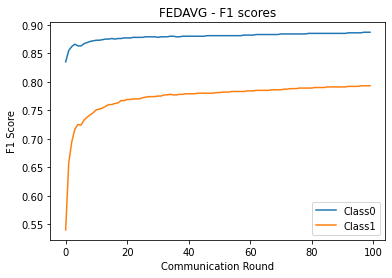

In [ ]:
plt.plot(fedavg_plot1)
plt.plot(fedavg_plot2)
plt.legend(['Class0', 'Class1'])
plt.xlabel('Communication Round')
plt.ylabel('F1 Score')
plt.title('FEDAVG - F1 scores')



---
## FED MMD



In [ ]:
def FEDMMD(g, model, sentiment_labels, i): 

    glob_mod = copy.deepcopy(model)

    sentiment_labels = torch.from_numpy(sentiment_labels[i])
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate, weight_decay = die)
    
    best_val_acc = 0
    best_test_acc = 0
    best_f1 = 0

    features = g.ndata['feat']
    labels = g.ndata['label']
    w_lambda = 0.1

    train_mask, val_mask, test_mask = mask_generator(len(labels), epochs)

    for e in range(epochs):
        # Forward
        [logits1, logits2] = model(g, features)

        [glob_logits1, glob_logits2] = glob_mod(g, features)
        
        # Compute prediction
        pred1 = logits1.argmax(1)
        pred2 = logits2.argmax(1)

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        loss1 = F.cross_entropy(logits1[train_mask[e]], labels[train_mask[e]])

        criterion = torch.nn.CrossEntropyLoss() # This criterion combines LogSoftmax and NLLLoss in one single class.
        loss2 = criterion(logits2[train_mask[e]], sentiment_labels[train_mask[e]])

        loss_cls = (2*loss1 + loss2)/3

        mean = np.average(logits1.detach().numpy(), axis = 1)
        glob_mean = np.average(glob_logits1.detach().numpy(), axis = 1)
        loss_mmd = np.exp(-1 * ((mean[0] - glob_mean[0])**2 + (mean[1] - glob_mean[1])**2)/.1)

        loss = loss_cls + w_lambda * loss_mmd
        
        # Compute accuracy on training/validation/test
        train_acc1 = (pred1[train_mask[e]] == labels[train_mask[e]]).float().mean()
        val_acc1 = (pred1[val_mask[e]] == labels[val_mask[e]]).float().mean()

        #print(pred2, sentiment_labels)
        train_acc2 = (pred2[train_mask[e]] == sentiment_labels[train_mask[e]]).float().mean()
        val_acc2 = (pred2[val_mask[e]] == sentiment_labels[val_mask[e]]).float().mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        f1_0, f1_1 = evaluate(model, g, features, labels, val_mask[e], False, False)

        
        if best_f1 < (f1_0 + f1_1)/2:
            best_val_acc = val_acc1
            best_f1 = (f1_0 + f1_1)/2
            torch.save(model.state_dict(), '/content/drive/MyDrive/Tweets/UnivEnc/UE_IID_FEDMMD.pt')

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    # print('Client {}, loss cls : {:.3f}, loss mdd: {:.3f} node train acc : {:.3f} node val acc : {:.3f}'.format(
    #    i, loss_cls, loss_mmd, train_acc1, val_acc1))
    model.load_state_dict(torch.load('/content/drive/MyDrive/Tweets/UnivEnc/UE_IID_FEDMMD.pt'))
            #print('Client {}, sent loss : {:.3f}, sent train acc : {:.3f} sent val acc : {:.3f}, sent test acc : {:.3f}'.format(i, loss2, train_acc2, val_acc2, test_acc2))
            

In [ ]:
# FEDMMD
fedmmd_f1_0 = 0
fedmmd_f1_1 = 0
fedmmd = 0

fed_glob, all_clients = fed_setting()

print('FedMMD ->', 'epochs:', epochs, 'comm_round:', comm_round, 'LR:', learn_rate, 'decay:', die)
fedmmd_plot1 = []
fedmmd_plot2 = []
for comm_rounds in range(comm_round):
        
    #print('Communication Round :', comm_rounds+1)

    train_ind = random.sample(range(0, len(all_clients)), 3)
    train_ind = sorted(train_ind)

    test_ind = [i for i in range(len(all_clients))]
    
    for ind in train_ind:
        test_ind.remove(ind)
        
    train_clients = []
    test_clients = []

    for ind in train_ind:
        train_clients.append(all_clients[ind])
    
    for clients in all_clients:
        if clients not in train_clients:
            test_clients.append(clients)

    old_params = []
    new_params = []
    
    for ind,client_model in zip(train_ind, train_clients):
        
        dummy = []

        FEDMMD(graph[ind], client_model, sentiment_labels, ind)


    fed_glob.load_state_dict(zero_client.state_dict()) 

    for ind in train_ind:
        for p1, p2 in zip(fed_glob.parameters(), all_clients[ind].parameters()):
            p1.data = p1.data + p2.data


    for p in fed_glob.parameters():
        p.data = p.data / len(train_ind)

    for client_model in all_clients:
        client_model.load_state_dict(fed_glob.state_dict())  
        

    for ind, client_model in zip(test_ind, test_clients):
        
        #print('\nTesting on Client', ind)
        f10, f11 = evaluate(fed_glob, graph[ind], node_features[ind], node_labels[ind], [True for i in range(len(node_labels[ind]))], False, False)
        fedmmd_f1_0 += f10
        fedmmd_f1_1 += f11
        fedmmd += 1

    if len(test_clients) == 0:

        #Testing on all clients (test) data
        for ind in range(len(all_clients)):
            print('\nTesting on Client', ind)
            test_mask = [False for i in range(len(node_labels[ind]))]
            test_mask[:int(test_split*len(node_labels[ind]))] = [True for i in range(int(test_split*len(node_labels[ind])))]
            f10, f11 = evaluate(fed_glob, graph[ind], node_features[ind], node_labels[ind], test_mask, False, False)
            fedmmd_f1_0 += f10
            fedmmd_f1_1 += f11
            fedmmd += 1

    # print('----------------------------------------')
    print('Communication Round', comm_rounds,'-> Class0 avg F1 :', np.round(fedmmd_f1_0/fedmmd, 3), '; Class1 avg F1:', np.round(fedmmd_f1_1/fedmmd, 3))
   
    fedmmd_plot1.append(np.round(fedmmd_f1_0/fedmmd, 3))
    fedmmd_plot2.append(np.round(fedmmd_f1_1/fedmmd, 3))

torch.save(fed_glob.state_dict(), '/content/drive/MyDrive/Tweets/UnivEnc/UE_IID_FEDMMD.pt')

# print('-----------------------------------------')
# print('Average class 0 F1 score :', np.round(fedmmd_f1_0/fedmmd, 3))
# print('Average class 1 F1 score :', np.round(fedmmd_f1_1/fedmmd, 3))

FedMMD -> epochs: 10 comm_round: 100 LR: 0.01 decay: 0.001
Communication Round 0 -> Class0 avg F1 : 0.865 ; Class1 avg F1: 0.74
Communication Round 1 -> Class0 avg F1 : 0.868 ; Class1 avg F1: 0.755
Communication Round 2 -> Class0 avg F1 : 0.868 ; Class1 avg F1: 0.737
Communication Round 3 -> Class0 avg F1 : 0.87 ; Class1 avg F1: 0.732
Communication Round 4 -> Class0 avg F1 : 0.871 ; Class1 avg F1: 0.742
Communication Round 5 -> Class0 avg F1 : 0.871 ; Class1 avg F1: 0.744
Communication Round 6 -> Class0 avg F1 : 0.874 ; Class1 avg F1: 0.752
Communication Round 7 -> Class0 avg F1 : 0.876 ; Class1 avg F1: 0.759
Communication Round 8 -> Class0 avg F1 : 0.876 ; Class1 avg F1: 0.762
Communication Round 9 -> Class0 avg F1 : 0.876 ; Class1 avg F1: 0.766
Communication Round 10 -> Class0 avg F1 : 0.876 ; Class1 avg F1: 0.767
Communication Round 11 -> Class0 avg F1 : 0.877 ; Class1 avg F1: 0.769
Communication Round 12 -> Class0 avg F1 : 0.877 ; Class1 avg F1: 0.77
Communication Round 13 -> Class



---



---



## FEDOPT

In [ ]:
def FEDOPT(g, model, sentiment_labels, i): 

    sentiment_labels = torch.from_numpy(sentiment_labels[i])
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate, weight_decay = die)
    
    best_val_acc = 0
    best_test_acc = 0
    best_f1 = 0

    features = g.ndata['feat']
    labels = g.ndata['label']
    w_lambda = 0.1

    train_mask, val_mask, test_mask = mask_generator(len(labels), epochs)

    for e in range(epochs):
        # Forward
        [logits1, logits2] = model(g, features)
        
        # Compute prediction
        pred1 = logits1.argmax(1)
        pred2 = logits2.argmax(1)


        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        loss1 = F.cross_entropy(logits1[train_mask[e]], labels[train_mask[e]])

        criterion = torch.nn.CrossEntropyLoss() # This criterion combines LogSoftmax and NLLLoss in one single class.
        loss2 = criterion(logits2[train_mask[e]], sentiment_labels[train_mask[e]])

        loss = (2*loss1 + loss2)/3

        # Compute accuracy on training/validation/test
        train_acc1 = (pred1[train_mask[e]] == labels[train_mask[e]]).float().mean()
        val_acc1 = (pred1[val_mask[e]] == labels[val_mask[e]]).float().mean()

        #print(pred2, sentiment_labels)
        train_acc2 = (pred2[train_mask[e]] == sentiment_labels[train_mask[e]]).float().mean()
        val_acc2 = (pred2[val_mask[e]] == sentiment_labels[val_mask[e]]).float().mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        f1_0, f1_1 = evaluate(model, g, features, labels, val_mask[e], False, False)

        
        if best_f1 < (f1_0 + f1_1)/2:
            best_val_acc = val_acc1
            best_f1 = (f1_0 + f1_1)/2
            torch.save(model.state_dict(), '/content/drive/MyDrive/Tweets/UnivEnc/UE_IID_FEDOPT_deletable.pt')

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    # print('Client {}, node loss : {:.3f}, node train acc : {:.3f} node val acc : {:.3f}'.format(
    #     i, loss, train_acc1, val_acc1))

    model.load_state_dict(torch.load('/content/drive/MyDrive/Tweets/UnivEnc/UE_IID_FEDOPT_deletable.pt'))


In [ ]:
# FEDADAGRAD

fedadagrad_f1_0 = 0
fedadagrad_f1_1 = 0
fedadagrad = 0

fed_glob, all_clients = fed_setting()

dummy_param = []
fedadagrad_plot1 = []
fedadagrad_plot2 = []

print('FedAdagrad ->', 'epochs:', epochs, 'comm_round:', comm_round, 'LR:', learn_rate, 'decay:', die)

for p in all_clients[0].parameters():
    dummy_param.append(p*0)
    
vt = 10e-2
global_learn_rate = 10
tow = 10e-0


beta1 = 0

del_client = dummy_param.copy()
del_global = dummy_param.copy()


for comm_rounds in range(comm_round):

    # print('Communication Round :', comm_rounds+1)

    train_ind = random.sample(range(0, len(all_clients)), 3)
    train_ind = sorted(train_ind)

    test_ind = [i for i in range(len(all_clients))]
    
    for ind in train_ind:
        test_ind.remove(ind)
        
    train_clients = []
    test_clients = []

    for ind in train_ind:
        train_clients.append(all_clients[ind])
    
    for clients in all_clients:
        if clients not in train_clients:
            test_clients.append(clients)

    for client_model in all_clients:
        client_model.load_state_dict(fed_glob.state_dict()) 

    for ind in train_ind:        
        
        FEDOPT(graph[ind], all_clients[ind], sentiment_labels, ind)

        dump = 0
        for p1, p2 in zip(all_clients[ind].parameters(), fed_glob.parameters()):
            del_client[dump] += p1.data - p2.data
            dump += 1
        
    for dump in range(len(del_global)):
        del_global[dump] = (beta1 * del_global[dump]) + ((1 - beta1)*del_client[dump]/len(train_ind))
    

    for p in del_global:
        vt += torch.sum(p.data**2)

    dump = 0

    for param in fed_glob.parameters():    
        param.data = param.data + (global_learn_rate * del_global[dump] / (torch.sqrt(vt) + tow))
        dump += 1


    for ind, client_model in zip(test_ind, test_clients):
        
        # print('\nTesting on Client', ind)
        f10, f11 = evaluate(fed_glob, graph[ind], node_features[ind], node_labels[ind], [True for i in range(len(node_labels[ind]))], False, False)
        fedadagrad_f1_0 += f10
        fedadagrad_f1_1 += f11
        fedadagrad += 1
    
    if len(test_clients) == 0:

        #Testing on all clients (test) data
        for ind in range(len(all_clients)):
            # print('\nTesting on Client', ind)
            test_mask = [False for i in range(len(node_labels[ind]))]
            test_mask[:int(test_split*len(node_labels[ind]))] = [True for i in range(int(test_split*len(node_labels[ind])))]
            f10, f11 = evaluate(fed_glob, graph[ind], node_features[ind], node_labels[ind], test_mask, False, False)
            fedadagrad_f1_0 += f10
            fedadagrad_f1_1 += f11
            fedadagrad += 1

    # print('Communication Round', comm_rounds,'-> Class0 avg F1 :', np.round(fedavg_f1_0/fedavg, 3), '; Class1 avg F1:', np.round(fedavg_f1_1/fedavg, 3))
    print('Communication Round', comm_rounds,'-> Class0 avg F1 :', np.round(fedadagrad_f1_0/fedadagrad, 3), '; Class1 avg F1:', np.round(fedadagrad_f1_1/fedadagrad, 3))
    fedadagrad_plot1.append(np.round(fedadagrad_f1_0/fedadagrad, 3))
    fedadagrad_plot2.append(np.round(fedadagrad_f1_1/fedadagrad, 3))
    # print('----------------------------------------')

torch.save(fed_glob.state_dict(), '/content/drive/MyDrive/Tweets/UnivEnc/UE_IID_FEDADAGRAD.pt')

# print('-----------------------------------------')
# print('Average class 0 F1 score :', np.round(fedadagrad_f1_0/fedadagrad, 3))
# print('Average class 1 F1 score :', np.round(fedadagrad_f1_1/fedadagrad, 3))

FedAdagrad -> epochs: 10 comm_round: 100 LR: 0.01 decay: 0.001
Communication Round 0 -> Class0 avg F1 : 0.835 ; Class1 avg F1: 0.69
Communication Round 1 -> Class0 avg F1 : 0.85 ; Class1 avg F1: 0.695
Communication Round 2 -> Class0 avg F1 : 0.858 ; Class1 avg F1: 0.698
Communication Round 3 -> Class0 avg F1 : 0.859 ; Class1 avg F1: 0.694
Communication Round 4 -> Class0 avg F1 : 0.86 ; Class1 avg F1: 0.69
Communication Round 5 -> Class0 avg F1 : 0.86 ; Class1 avg F1: 0.687
Communication Round 6 -> Class0 avg F1 : 0.86 ; Class1 avg F1: 0.686
Communication Round 7 -> Class0 avg F1 : 0.861 ; Class1 avg F1: 0.69
Communication Round 8 -> Class0 avg F1 : 0.862 ; Class1 avg F1: 0.696
Communication Round 9 -> Class0 avg F1 : 0.864 ; Class1 avg F1: 0.703
Communication Round 10 -> Class0 avg F1 : 0.865 ; Class1 avg F1: 0.708
Communication Round 11 -> Class0 avg F1 : 0.865 ; Class1 avg F1: 0.713
Communication Round 12 -> Class0 avg F1 : 0.866 ; Class1 avg F1: 0.718
Communication Round 13 -> Class

In [ ]:
# FEDADAM 

fedadam_f1_0 = 0
fedadam_f1_1 = 0
fedadam = 0

fed_glob, all_clients = fed_setting()

dummy_param = []

for p in all_clients[0].parameters():
    dummy_param.append(p*0)
    
vt = 10e-1
global_learn_rate = 10e-3
tow = 10

beta1 = 0.9
beta2 = 0.99

fedadam_plot1 = []
fedadam_plot2 = []

del_client = dummy_param.copy()
del_global = dummy_param.copy()

print('FedAdam ->', 'epochs:', epochs, 'comm_round:', comm_round, 'LR:', learn_rate, 'decay:', die)

for comm_rounds in range(comm_round):

    # print('Communication Round :', comm_rounds+1)

    train_ind = random.sample(range(0, len(all_clients)), 3)
    train_ind = sorted(train_ind)

    test_ind = [i for i in range(len(all_clients))]
    
    for ind in train_ind:
        test_ind.remove(ind)
        
    train_clients = []
    test_clients = []

    for ind in train_ind:
        train_clients.append(all_clients[ind])
    
    for clients in all_clients:
        if clients not in train_clients:
            test_clients.append(clients)

    for client_model in all_clients:
        client_model.load_state_dict(fed_glob.state_dict()) 

    for ind in train_ind:        
        
        FEDOPT(graph[ind], all_clients[ind], sentiment_labels, ind)

        dump = 0
        for p1, p2 in zip(all_clients[ind].parameters(), fed_glob.parameters()):
            del_client[dump] += p1.data - p2.data
            dump += 1
        
    for dump in range(len(del_global)):
        del_global[dump] = (beta1 * del_global[dump]) + ((1 - beta1)*del_client[dump]/len(train_ind))
    

    for p in del_global:
        vt += torch.sum(p.data**2)

    dump = 0
    for param in fed_glob.parameters():
        
        param.data = (beta2 * param.data) + ((1 - beta2) * (global_learn_rate * del_global[dump] / (torch.sqrt(vt) + tow)))
        dump += 1
  

    for ind, client_model in zip(test_ind, test_clients):
        
        # print('\nTesting on Client', ind)
        f10, f11 = evaluate(fed_glob, graph[ind], node_features[ind], node_labels[ind], [True for i in range(len(node_labels[ind]))], False, False)
        fedadam_f1_0 += f10
        fedadam_f1_1 += f11
        fedadam += 1
    
    if len(test_clients) == 0:

        # Testing on all clients (test) data
        for ind in range(len(all_clients)):
            # print('\nTesting on Client', ind)
            test_mask = [False for i in range(len(node_labels[ind]))]
            test_mask[:int(test_split*len(node_labels[ind]))] = [True for i in range(int(test_split*len(node_labels[ind])))]
            f10, f11 = evaluate(fed_glob, graph[ind], node_features[ind], node_labels[ind], test_mask, False, False)
            fedadam_f1_0 += f10
            fedadam_f1_1 += f11
            fedadam += 1

    print('Communication Round', comm_rounds,'-> Class0 avg F1 :', np.round(fedadam_f1_0/fedadam, 3), '; Class1 avg F1:', np.round(fedadam_f1_1/fedadam, 3))
    fedadam_plot1.append(np.round(fedadam_f1_0/fedadam, 3))
    fedadam_plot2.append(np.round(fedadam_f1_1/fedadam, 3))
    # print('----------------------------------------')

torch.save(fed_glob.state_dict(), '/content/drive/MyDrive/Tweets/UnivEnc/UE_IID_FEDADAM.pt')

# print('-----------------------------------------')
# print('Average class 0 F1 score :', np.round(fedadam_f1_0/fedadam, 3))
# print('Average class 1 F1 score :', np.round(fedadam_f1_1/fedadam, 3))

FedAdam -> epochs: 10 comm_round: 100 LR: 0.01 decay: 0.001
Communication Round 0 -> Class0 avg F1 : 0.745 ; Class1 avg F1: 0.655
Communication Round 1 -> Class0 avg F1 : 0.748 ; Class1 avg F1: 0.66
Communication Round 2 -> Class0 avg F1 : 0.75 ; Class1 avg F1: 0.667
Communication Round 3 -> Class0 avg F1 : 0.749 ; Class1 avg F1: 0.662
Communication Round 4 -> Class0 avg F1 : 0.748 ; Class1 avg F1: 0.661
Communication Round 5 -> Class0 avg F1 : 0.745 ; Class1 avg F1: 0.657
Communication Round 6 -> Class0 avg F1 : 0.745 ; Class1 avg F1: 0.657
Communication Round 7 -> Class0 avg F1 : 0.744 ; Class1 avg F1: 0.657
Communication Round 8 -> Class0 avg F1 : 0.745 ; Class1 avg F1: 0.659
Communication Round 9 -> Class0 avg F1 : 0.745 ; Class1 avg F1: 0.658
Communication Round 10 -> Class0 avg F1 : 0.744 ; Class1 avg F1: 0.657
Communication Round 11 -> Class0 avg F1 : 0.743 ; Class1 avg F1: 0.657
Communication Round 12 -> Class0 avg F1 : 0.744 ; Class1 avg F1: 0.658
Communication Round 13 -> Cla

In [ ]:
# FEDCOMB

fedcomb_f1_0 = 0
fedcomb_f1_1 = 0
fedcomb = 0

fed_glob, all_clients = fed_setting()

dummy_param = []

for p in all_clients[0].parameters():
    dummy_param.append(p*0)

fedcomb_plot1 = []
fedcomb_plot2 = []

vt = 10e-2
global_learn_rate = 10
tow = 10e-0


beta1 = 0

del_client = dummy_param.copy()
del_global = dummy_param.copy()

print('FedComb ->', 'epochs:', epochs, 'comm_round:', comm_round, 'LR:', learn_rate, 'decay:', die)

for comm_rounds in range(comm_round):

    # print('Communication Round :', comm_rounds+1)

    train_ind = random.sample(range(0, len(all_clients)), 3)
    train_ind = sorted(train_ind)

    test_ind = [i for i in range(len(all_clients))]
    
    for ind in train_ind:
        test_ind.remove(ind)
        
    train_clients = []
    test_clients = []

    for ind in train_ind:
        train_clients.append(all_clients[ind])
    
    for clients in all_clients:
        if clients not in train_clients:
            test_clients.append(clients)

    for client_model in all_clients:
        client_model.load_state_dict(fed_glob.state_dict()) 

    for ind in train_ind:        
        
        FEDMMD(graph[ind], all_clients[ind], sentiment_labels, ind)

        dump = 0
        for p1, p2 in zip(all_clients[ind].parameters(), fed_glob.parameters()):
            del_client[dump] += p1.data - p2.data
            dump += 1
        
    for dump in range(len(del_global)):
        del_global[dump] = (beta1 * del_global[dump]) + ((1 - beta1)*del_client[dump]/len(train_ind))
    

    for p in del_global:
        vt += torch.sum(p.data**2)

    dump = 0

    for param in fed_glob.parameters():    
        param.data = param.data + (global_learn_rate * del_global[dump] / (torch.sqrt(vt) + tow))
        dump += 1


    for ind, client_model in zip(test_ind, test_clients):
        
        # print('\nTesting on Client', ind)
        f10, f11 = evaluate(fed_glob, graph[ind], node_features[ind], node_labels[ind], 
                            [True for i in range(len(node_labels[ind]))], False, False)

        fedcomb_f1_0 += f10
        fedcomb_f1_1 += f11
        fedcomb += 1
    
    if len(test_clients) == 0:

        # Testing on all clients (test) data
        for ind in range(len(all_clients)):
            # print('\nTesting on Client', ind)
            test_mask = [False for i in range(len(node_labels[ind]))]
            test_mask[:int(test_split*len(node_labels[ind]))] = [True for i in range(int(test_split*len(node_labels[ind])))]
            f10, f11 = evaluate(fed_glob, graph[ind], node_features[ind], node_labels[ind], test_mask, False, False)
            fedcomb_f1_0 += f10
            fedcomb_f1_1 += f11
            fedcomb += 1

    print('Communication Round', comm_rounds,'-> Class0 avg F1 :', np.round(fedcomb_f1_0/fedcomb, 3), '; Class1 avg F1:', np.round(fedcomb_f1_1/fedcomb, 3))
    fedcomb_plot1.append(np.round(fedcomb_f1_0/fedcomb, 3))
    fedcomb_plot2.append(np.round(fedcomb_f1_1/fedcomb, 3))

    # print('----------------------------------------')

torch.save(fed_glob.state_dict(), '/content/drive/MyDrive/Tweets/UnivEnc/UE_IID_FEDCOMB.pt')

# print('-----------------------------------------')
# print('Average class 0 F1 score :', np.round(fedcomb_f1_0/fedcomb, 3))
# print('Average class 1 F1 score :', np.round(fedcomb_f1_1/fedcomb, 3))

FedComb -> epochs: 10 comm_round: 100 LR: 0.01 decay: 0.001
Communication Round 0 -> Class0 avg F1 : 0.845 ; Class1 avg F1: 0.7
Communication Round 1 -> Class0 avg F1 : 0.862 ; Class1 avg F1: 0.73
Communication Round 2 -> Class0 avg F1 : 0.865 ; Class1 avg F1: 0.73
Communication Round 3 -> Class0 avg F1 : 0.865 ; Class1 avg F1: 0.73
Communication Round 4 -> Class0 avg F1 : 0.864 ; Class1 avg F1: 0.733
Communication Round 5 -> Class0 avg F1 : 0.862 ; Class1 avg F1: 0.732
Communication Round 6 -> Class0 avg F1 : 0.861 ; Class1 avg F1: 0.73
Communication Round 7 -> Class0 avg F1 : 0.861 ; Class1 avg F1: 0.729
Communication Round 8 -> Class0 avg F1 : 0.861 ; Class1 avg F1: 0.731
Communication Round 9 -> Class0 avg F1 : 0.861 ; Class1 avg F1: 0.731
Communication Round 10 -> Class0 avg F1 : 0.862 ; Class1 avg F1: 0.732
Communication Round 11 -> Class0 avg F1 : 0.862 ; Class1 avg F1: 0.735
Communication Round 12 -> Class0 avg F1 : 0.864 ; Class1 avg F1: 0.739
Communication Round 13 -> Class0 

In [ ]:
print('FEDAVG')
print('Average class 0 F1 score :', np.round(fedavg_f1_0/fedavg, 3))
print('Average class 1 F1 score :', np.round(fedavg_f1_1/fedavg, 3))

print('\nFEDMMD')
print('Average class 0 F1 score :', np.round(fedmmd_f1_0/fedmmd, 3))
print('Average class 1 F1 score :', np.round(fedmmd_f1_1/fedmmd, 3))

print('\nFEDADAGRAD')
print('Average class 0 F1 score :', np.round(fedadagrad_f1_0/fedadagrad, 3))
print('Average class 1 F1 score :', np.round(fedadagrad_f1_1/fedadagrad, 3))

print('\nFEDADAM')
print('Average class 0 F1 score :', np.round(fedadam_f1_0/fedadam, 3))
print('Average class 1 F1 score :', np.round(fedadam_f1_1/fedadam, 3))

print('\nFEDCOMB')
print('Average class 0 F1 score :', np.round(fedcomb_f1_0/fedcomb, 3))
print('Average class 1 F1 score :', np.round(fedcomb_f1_1/fedcomb, 3))

FEDAVG
Average class 0 F1 score : 0.887
Average class 1 F1 score : 0.793

FEDMMD
Average class 0 F1 score : 0.887
Average class 1 F1 score : 0.794

FEDADAGRAD
Average class 0 F1 score : 0.888
Average class 1 F1 score : 0.78

FEDADAM
Average class 0 F1 score : 0.711
Average class 1 F1 score : 0.66

FEDCOMB
Average class 0 F1 score : 0.88
Average class 1 F1 score : 0.774




---



---



---



In [ ]:
print('Valid split:', valid_split)
print('Test split:', test_split)
print('Learning Rate:', learn_rate)
print('Decay rate:',die)
print('#Communication round:',comm_round)
print('#Epochs', epochs)

Valid split: 0.1
Test split: 0.2
Learning Rate: 0.01
Decay rate: 0.001
#Communication round: 100
#Epochs 10


Text(0.5, 1.0, 'FEDMMD - F1 scores')

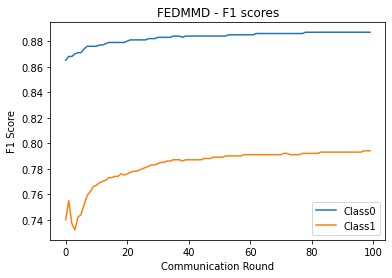

In [ ]:
plt.plot(fedmmd_plot1)
plt.plot(fedmmd_plot2)
plt.legend(['Class0', 'Class1'])
plt.xlabel('Communication Round')
plt.ylabel('F1 Score')
plt.title('FEDMMD - F1 scores')

Text(0.5, 1.0, 'FEDADAGRAD - F1 scores')

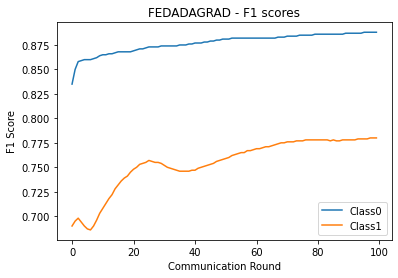

In [ ]:
plt.plot(fedadagrad_plot1)
plt.plot(fedadagrad_plot2)
plt.legend(['Class0', 'Class1'])
plt.xlabel('Communication Round')
plt.ylabel('F1 Score')
plt.title('FEDADAGRAD - F1 scores')

Text(0.5, 1.0, 'FEDADAM - F1 scores')

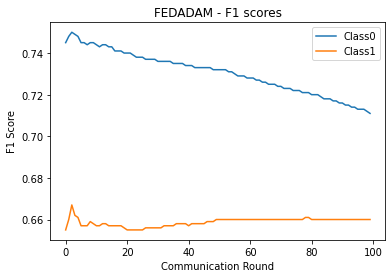

In [ ]:
plt.plot(fedadam_plot1)
plt.plot(fedadam_plot2)
plt.legend(['Class0', 'Class1'])
plt.xlabel('Communication Round')
plt.ylabel('F1 Score')
plt.title('FEDADAM - F1 scores')

In [ ]:
plt.plot(fedcomb_plot1)
plt.plot(fedcomb_plot2)
plt.legend(['Class0', 'Class1'])
plt.xlabel('Communication Round')
plt.ylabel('F1 Score')
plt.title('FEDCOMB - F1 scores')

Text(0.5, 1.0, 'FEDADCOMB - F1 scores')